In [1]:
# Imports
import functions
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
system = 'Kuramoto-Sivashinsky'  # Choose from 'Burgers', 'Diffusion', 'Kuramoto-Sivashinsky'
u, x, t = functions.load_data(system)
u_noisy = functions.add_noise(u, noise_percentage=20)

kernel_types = ['rbf', 'poly', 'sigmoid']
results = {}
smoothing_mse_list = []
functional_mse_list = []

In [3]:
for smoothing_kernel in kernel_types:
    smoothing_param_grid = functions.generate_param_grid(smoothing_kernel)
    best_smoothing_params, smoothing_mse_grid = functions.find_best_parameters(u, u_noisy, x, smoothing_kernel, smoothing_param_grid)
    smoothing_mse_list.extend([{'kernel': smoothing_kernel, **mse_record} for mse_record in smoothing_mse_grid])
    
    u_smooth = functions.kernel_smoothing(u_noisy, x, kernel=smoothing_kernel, **best_smoothing_params)
    derivatives = functions.kernel_spatial_derivatives(x, x, u_noisy, kernel=smoothing_kernel, order=4, **best_smoothing_params)
    ut, s = functions.calculate_ut_and_s(system, x, u_smooth, derivatives)
    
    for functional_kernel in kernel_types:
        functional_param_grid = functions.generate_param_grid(functional_kernel)
        best_functional_params, functional_mse_grid = functions.find_best_parameters(u, u_noisy, x, functional_kernel, functional_param_grid)
        functional_mse_list.extend([{'smoothing_kernel': smoothing_kernel, 'functional_kernel': functional_kernel, **mse_record} for mse_record in functional_mse_grid])
        
        P = functions.functional_form_PDE(s, s, ut, kernel=functional_kernel, **best_functional_params)
        mse = mean_squared_error(u, P)
        key = f"{smoothing_kernel}_smoothing_with_{functional_kernel}_functional"
        results[key] = {
            'smoothing_params': best_smoothing_params,
            'functional_params': best_functional_params,
            'mse': mse,
            'P': P
        }

d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:159: LinAlgWarning: Ill-conditioned matrix (rcond=1.10812e-19): result may not be accurate.
  u_smooth = U @ solve((U + reg * np.eye(Nx)), u_noisy)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:159: LinAlgWarning: Ill-conditioned matrix (rcond=6.17692e-20): result may not be accurate.
  u_smooth = U @ solve((U + reg * np.eye(Nx)), u_noisy)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:159: LinAlgWarning: Ill-conditioned matrix (rcond=2.81097e-20): result may not be accurate.
  u_smooth = U @ solve((U + reg * np.eye(Nx)), u_noisy)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:159: LinAlgWarning: Ill-conditioned matrix (rcond=2.75855e-20): result may not be accura

In [4]:
smoothing_mse_df = pd.DataFrame(smoothing_mse_list)
functional_mse_df = pd.DataFrame(functional_mse_list)
smoothing_mse_df.to_csv(f"results/{system}/smoothing_mse.csv", index=False)
functional_mse_df.to_csv(f"results/{system}/functional_mse.csv", index=False)

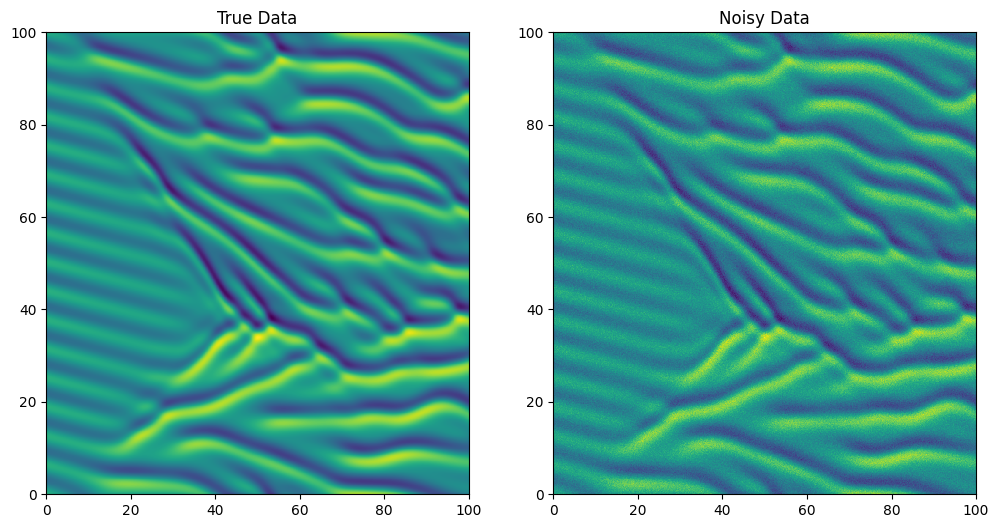

In [5]:
L1 = np.linspace(x[0], x[-1], len(x) + 1)
L2 = np.linspace(t[0], t[-1], len(t) + 1)

smoothing_comparison_fig1, smoothing_comarison_axs1 = plt.subplots(1, 2, figsize=(12, 6))
smoothing_comarison_axs1[0].pcolormesh(L2, L1, u)
smoothing_comarison_axs1[0].set(title="True Data")
smoothing_comarison_axs1[1].pcolormesh(L2, L1, u_noisy)
smoothing_comarison_axs1[1].set(title="Noisy Data")
smoothing_comparison_fig1.savefig(f"results/{system}/true_vs_noisy_data.png")

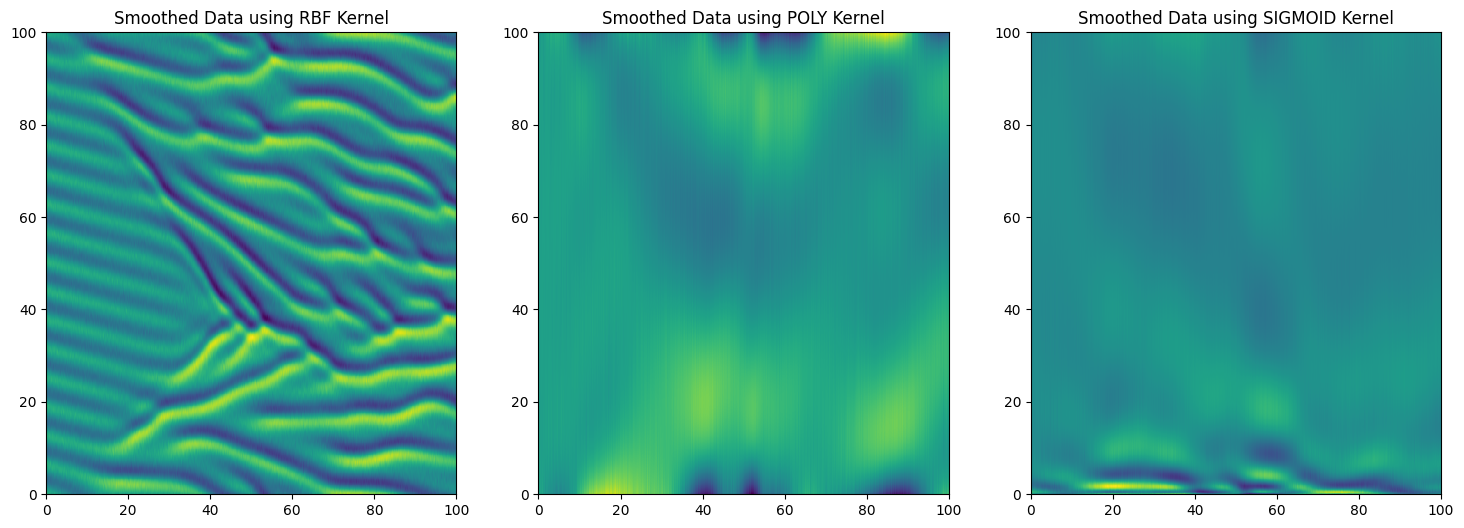

In [6]:
# Smoothed data comparison
smoothing_comparison_fig2, smoothing_comarison_axs2 = plt.subplots(1, 3, figsize=(18, 6))
for idx, smoothing_kernel in enumerate(kernel_types):
    best_smoothing_params = results[f"{smoothing_kernel}_smoothing_with_rbf_functional"]['smoothing_params']
    u_smooth = functions.kernel_smoothing(u_noisy, x, kernel=smoothing_kernel, **best_smoothing_params)
    smoothing_comarison_axs2[idx].pcolormesh(L2, L1, u_smooth)
    smoothing_comarison_axs2[idx].set(title=f"Smoothed Data using {smoothing_kernel.upper()} Kernel")
smoothing_comparison_fig2.savefig(f"results/{system}/smoothing_comparison.png")


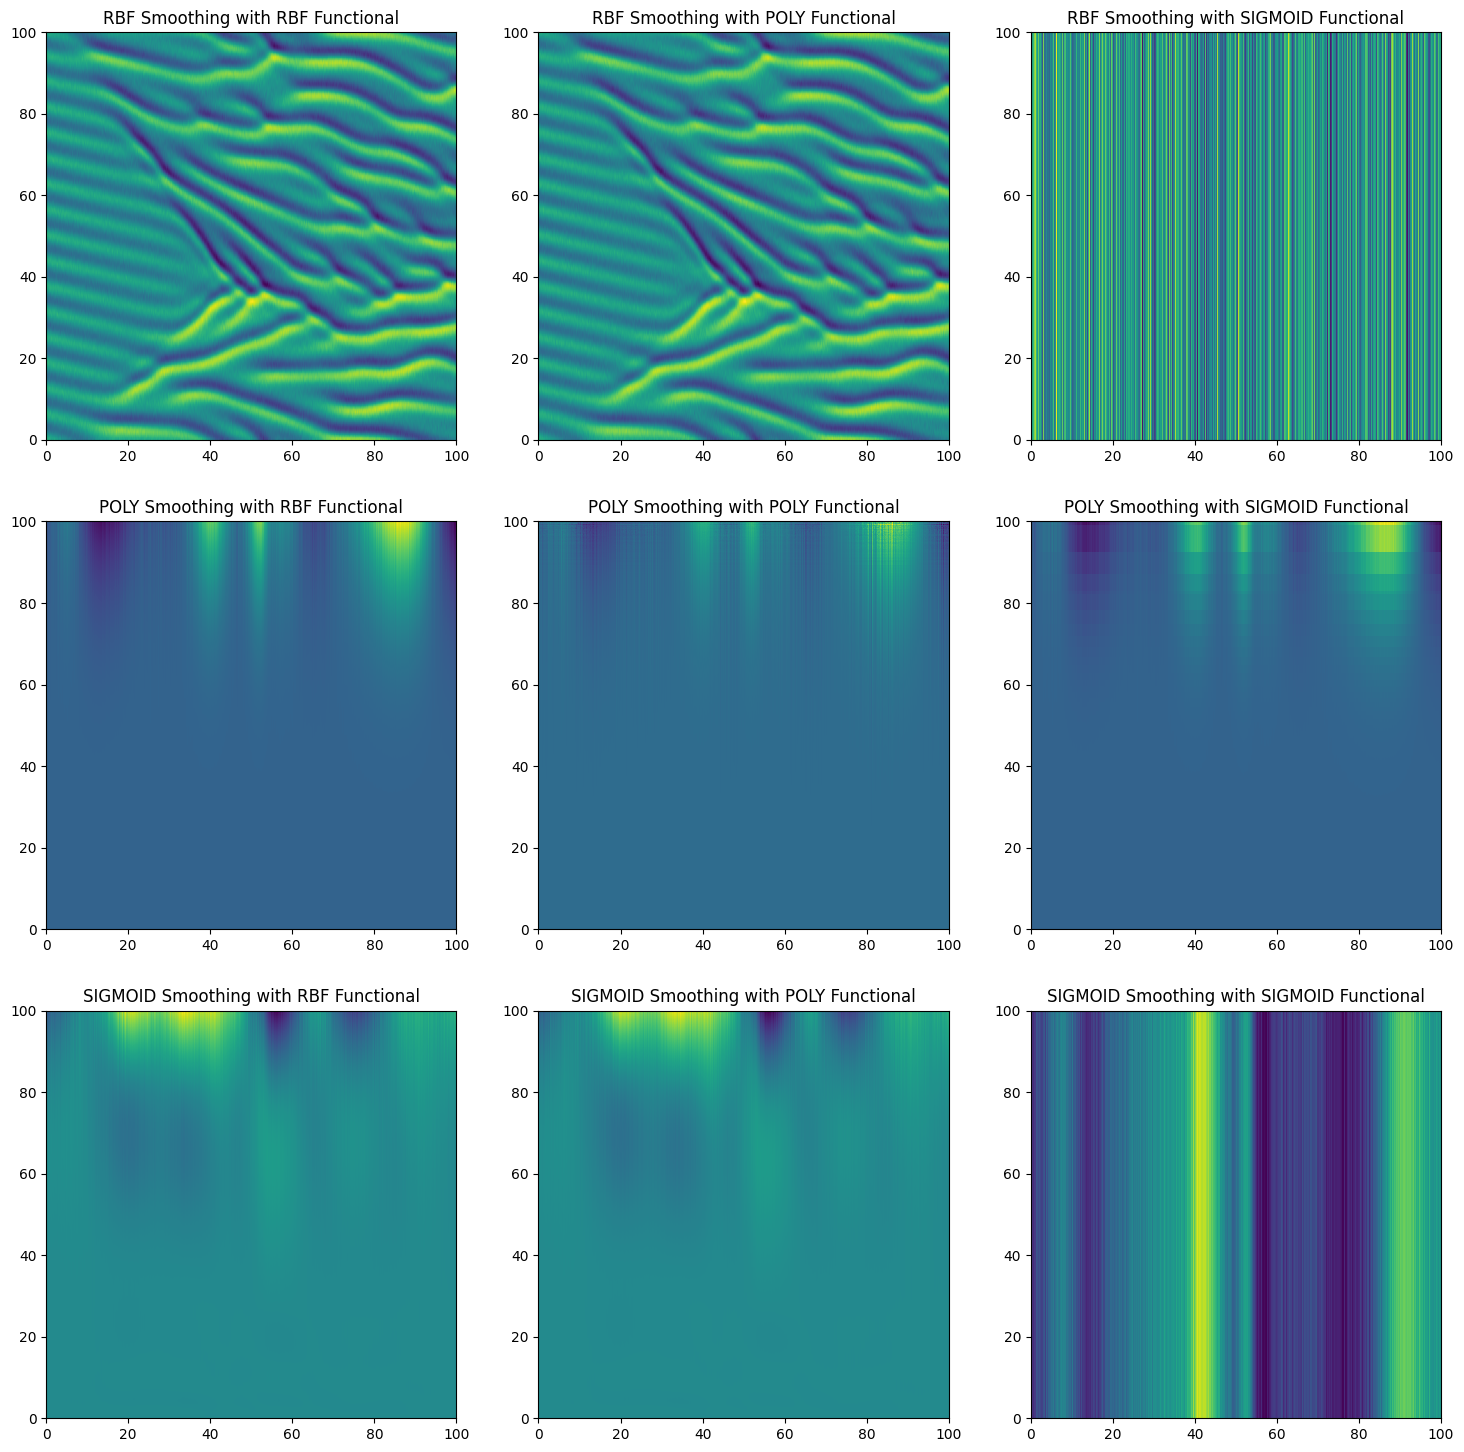

In [7]:
estimation_comparison_fig, estimation_comparison_axs = plt.subplots(3, 3, figsize=(18, 18))
for i, smoothing_kernel in enumerate(kernel_types):
    for j, functional_kernel in enumerate(kernel_types):
        key = f"{smoothing_kernel}_smoothing_with_{functional_kernel}_functional"
        P = results[key]['P']
        estimation_comparison_axs[i, j].pcolormesh(L2, L1, P)
        estimation_comparison_axs[i, j].set(title=f"{smoothing_kernel.upper()} Smoothing with {functional_kernel.upper()} Functional")
estimation_comparison_fig.savefig(f"results/{system}/functional_estimation_comparison.png")
